In [50]:
!pip install datasets torch torchvision gradio matplotlib seaborn tqdm transformers


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
from tqdm import tqdm
import copy

# 获取数据

In [52]:
# 加载含 train/validation/test 三个拆分的数据集
dataset = load_dataset("yashikota/birds-525-species-image-classification")
# 查看可用拆分
print(dataset)



DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 84635
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2625
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2625
    })
})


# 获取类别名称和数量

In [53]:
# 分别获取三个拆分
train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

# 查看 train 拆分的列
print(train_ds.column_names)  # 会输出 ['image', 'label']

# 提取类别名称和数量
class_names = train_ds.features['label'].names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")



['image', 'label']
Number of classes: 526


# 模型设置

In [54]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 加载模型

model = AutoModelForImageClassification.from_pretrained("chriamue/bird-species-classifier")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()  # 训练模式

EfficientNetForImageClassification(
  (efficientnet): EfficientNetModel(
    (embeddings): EfficientNetEmbeddings(
      (padding): ZeroPad2d((0, 1, 0, 1))
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid, bias=False)
      (batchnorm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): EfficientNetEncoder(
      (blocks): ModuleList(
        (0): EfficientNetBlock(
          (depthwise_conv): EfficientNetDepthwiseLayer(
            (depthwise_conv_pad): ZeroPad2d((0, 1, 0, 1))
            (depthwise_conv): EfficientNetDepthwiseConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
            (depthwise_norm): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
            (depthwise_act): SiLU()
          )
          (squeeze_excite): EfficientNetSqueezeExciteLayer(
            (squeeze): AdaptiveAvgPool2d(output

# Dataset 类

In [65]:
class HFBirdDataset(Dataset):
    def __init__(self, split='train', max_samples=None, extractor=None):
        self.dataset = load_dataset("yashikota/birds-525-species-image-classification", split=split)
        if max_samples:
            self.dataset = self.dataset.select(range(max_samples))
        self.extractor = extractor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        inputs = self.extractor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        return pixel_values, label

# 初始化 HF 图像预处理器（ViT）
extractor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# 加载数据集
train_dataset = HFBirdDataset(split='train', max_samples=80000, extractor=extractor)
val_dataset   = HFBirdDataset(split='validation', max_samples=2500, extractor=extractor)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# 创建 DataLoader

In [74]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=10, shuffle=False)



# 定义损失函数和优化器

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-7)




# 训练

In [75]:
num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for pixel_values, labels in train_bar:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)


    model.eval()
    correct = 0
    total = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]")
    with torch.no_grad():
        for pixel_values, labels in val_bar:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            preds = model(pixel_values=pixel_values).logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}, Val Accuracy: {acc:.2f}%")


Epoch 1 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Epoch 1 — Loss: 1.2868, Val Accuracy: 90.64%


Epoch 2 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.14it/s]


Epoch 2 — Loss: 0.4148, Val Accuracy: 93.76%


Epoch 3 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.24it/s]


Epoch 3 — Loss: 0.2579, Val Accuracy: 93.84%


Epoch 4 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.11it/s]


Epoch 4 — Loss: 0.1997, Val Accuracy: 94.12%


Epoch 5 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.18it/s]


Epoch 5 — Loss: 0.1633, Val Accuracy: 93.84%


Epoch 6 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.00it/s]


Epoch 6 — Loss: 0.1347, Val Accuracy: 95.68%


Epoch 7 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.13it/s]


Epoch 7 — Loss: 0.1140, Val Accuracy: 95.44%


Epoch 8 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.20it/s]


Epoch 8 — Loss: 0.1000, Val Accuracy: 96.04%


Epoch 9 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.26it/s]


Epoch 9 — Loss: 0.0831, Val Accuracy: 95.56%


Epoch 10 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.37it/s]


Epoch 10 — Loss: 0.0733, Val Accuracy: 95.52%


Epoch 11 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.26it/s]


Epoch 11 — Loss: 0.0635, Val Accuracy: 95.32%


Epoch 12 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.23it/s]


Epoch 12 — Loss: 0.0558, Val Accuracy: 96.24%


Epoch 13 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.33it/s]


Epoch 13 — Loss: 0.0504, Val Accuracy: 96.32%


Epoch 14 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.14it/s]


Epoch 14 — Loss: 0.0461, Val Accuracy: 95.68%


Epoch 15 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch 15 — Loss: 0.0416, Val Accuracy: 96.32%


Epoch 16 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.23it/s]


Epoch 16 — Loss: 0.0367, Val Accuracy: 95.96%


Epoch 17 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.30it/s]


Epoch 17 — Loss: 0.0329, Val Accuracy: 96.32%


Epoch 18 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.20it/s]


Epoch 18 — Loss: 0.0303, Val Accuracy: 96.60%


Epoch 19 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.38it/s]


Epoch 19 — Loss: 0.0280, Val Accuracy: 96.40%


Epoch 20 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.07it/s]


Epoch 20 — Loss: 0.0245, Val Accuracy: 96.48%


Epoch 21 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.29it/s]


Epoch 21 — Loss: 0.0231, Val Accuracy: 96.64%


Epoch 22 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.24it/s]


Epoch 22 — Loss: 0.0209, Val Accuracy: 96.52%


Epoch 23 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.20it/s]


Epoch 23 — Loss: 0.0197, Val Accuracy: 96.48%


Epoch 24 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch 24 — Loss: 0.0181, Val Accuracy: 96.40%


Epoch 25 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Epoch 25 — Loss: 0.0179, Val Accuracy: 95.48%


Epoch 26 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.25it/s]


Epoch 26 — Loss: 0.0164, Val Accuracy: 96.36%


Epoch 27 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.30it/s]


Epoch 27 — Loss: 0.0153, Val Accuracy: 96.64%


Epoch 28 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.16it/s]


Epoch 28 — Loss: 0.0149, Val Accuracy: 96.56%


Epoch 29 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.33it/s]


Epoch 29 — Loss: 0.0141, Val Accuracy: 96.04%


Epoch 30 [Validation]: 100%|██████████| 250/250 [00:11<00:00, 22.45it/s]

Epoch 30 — Loss: 0.0130, Val Accuracy: 96.36%


# 绘制训练损失和验证准确率

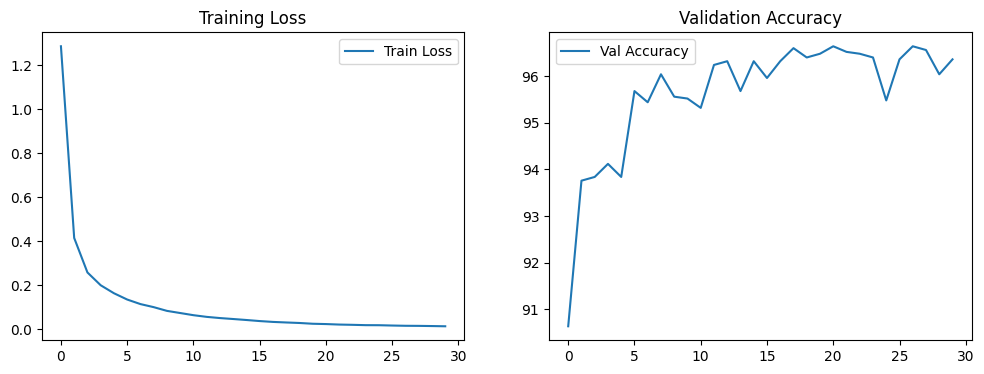

In [76]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.savefig('training_metrics.png')


# 混淆矩阵

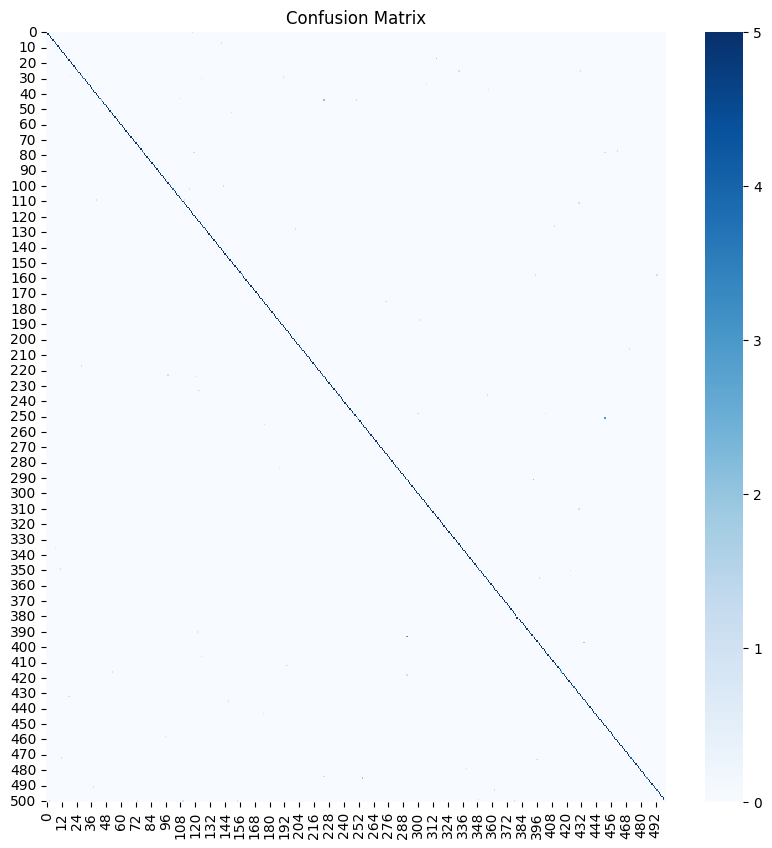

In [81]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)  # Use outputs.logits instead of outputs
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')


# 定义预测函数

In [98]:
def predict(image):
    # 应用测试转换
    image = test_transform(image).unsqueeze(0).to(device)
    # 设置模型为评估模式
    model.eval()
    # 无梯度预测
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    # 映射预测索引到鸟类名称
    predicted_class = class_names[predicted.item()]
    return f"鸟类种类：{predicted_class}"


# 创建 Gradio 界面

In [99]:
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Bird Species Classifier",
)

# 启动 Gradio 界面
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b7255c09c807ea215c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


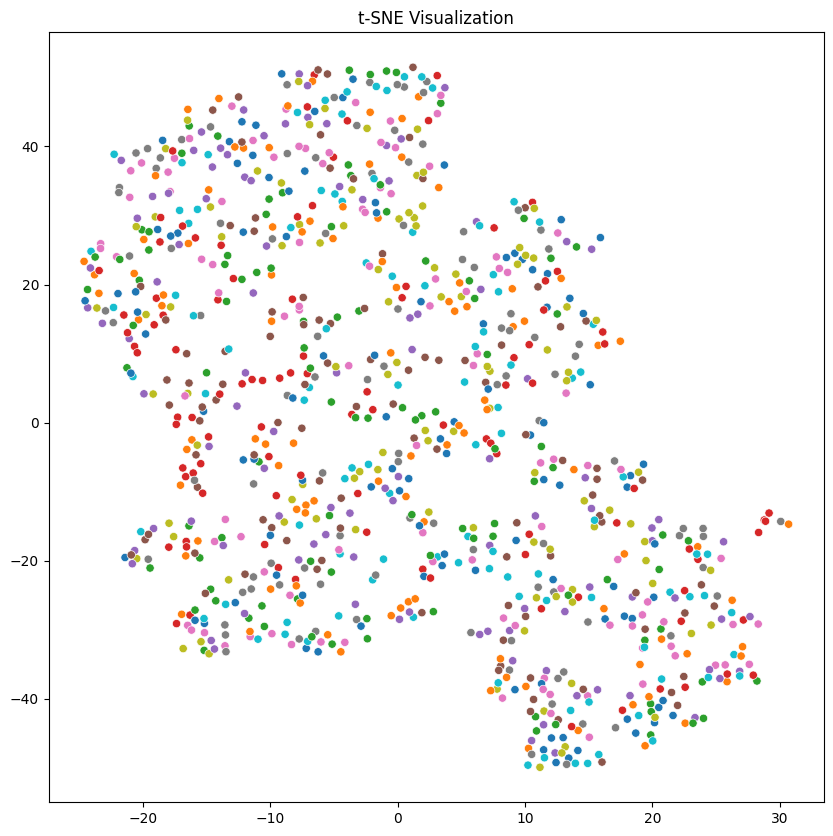

In [100]:
features = []
labels_list = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model.efficientnet(images)
        feats = outputs.last_hidden_state.mean([1, 2])
        features.append(feats.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

features = np.vstack(features)
labels_list = np.array(labels_list)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features[:1000])

plt.figure(figsize=(10, 10))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels_list[:1000], palette="tab10", legend=False)
plt.title('t-SNE Visualization')
plt.savefig('tsne_visualization.png')
plt.show()
